**Resistencia a compresión del concreto**

Uno de los factores más importantes, desde mi humilde punto de vista, en la ingeniería civil es conocer la resistencia a la compresión del concreto. Este valor se utiliza en todos los cálculos para el diseño estructural de obras en concreto reforzado, ya que garantiza principalmente la seguridad frente a las solicitaciones que experimenta la estructura.
Pero, ¿es fácil obtener este valor? ¿De qué depende? ¿Podemos usar redes neuronales para predecirlo e intentar ser más eficientes al diseñar una mezcla?

El estado del arte y los años de experiencia nos han demostrado que la resistencia final a compresión del concreto depende críticamente de la microestructura resultante del proceso de hidratación del cemento. Por ende, el agua juega un papel fundamental en el diseño de la mezcla. En esencia, la resistencia máxima está relacionada con la cantidad y distribución del gel C–S–H formado, así como con la porosidad remanente en la matriz de pasta. Es evidente, entonces, que el concreto debe tener una porosidad adecuada, lo cual resulta saludable desde el punto de vista estructural. Una de las razones principales es que permite crear espacio para encapsular agua, evitando así esfuerzos negativos generados por su presencia.

Evidentemente, según la teoría del gel-espacio, la resistencia σ del concreto depende del cociente gel/espacio (es decir, gel de hidratación frente al volumen total no gel), el cual está determinado, a su vez, por el grado de hidratación del cemento y por la relación agua/cemento (w/c).

Para profundizar en este análisis, es importante mencionar la ecuación de Powers, a partir de la cual se pueden extraer algunas conclusiones:

La clásica ley de Powers muestra que σ se escala como (gel/espacio)^n, con un exponente n ≈ 0.8–1.

En términos prácticos, esto significa que, a igualdad de w/c, aumentar la cantidad de cemento (es decir, más gel potencial) eleva la resistencia, aunque de forma no lineal.

Un cemento con mayor contenido de C₃S reactivo o con una mayor finura producirá una mayor “fuerza intrínseca” β dentro del modelo de Powers, lo cual incrementa la resistencia de la pasta.

(Wang, 2017).



In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
data = pd.read_excel("Concrete_Data.xls")
data.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,f´c
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cement               1030 non-null   float64
 1   Blast Furnace Slag   1030 non-null   float64
 2   Fly Ash              1030 non-null   float64
 3   Water                1030 non-null   float64
 4   Superplasticizer     1030 non-null   float64
 5   Coarse Aggregate     1030 non-null   float64
 6   Fine Aggregate       1030 non-null   float64
 7   Age                  1030 non-null   int64  
 8   f´c                  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


La base de datos que estoy utilizando en este artículo es pública y la encontré en la página del UC Irvine Machine Learning Repository. Esta fuente ha despertado en mí un gran interés por desarrollar una red neuronal y evaluar su eficiencia.
Observé que cuento con 1.030 casos, en los cuales se relacionan las variables típicas involucradas en el diseño de mezclas de concreto.

1. Es importante señalar que no hay datos nulos, lo verificaré mediante una línea de código que no hayand datos repetidos.



In [21]:
#Filas repetidas en los registros
print(f"Tamaño del dataset antes de eliminar duplicados: {data.shape}")
data.drop_duplicates(inplace=True)
print(f"Tamaño del dataset después de eliminar duplicados: {data.shape}")

Tamaño del dataset antes de eliminar duplicados: (1030, 9)
Tamaño del dataset después de eliminar duplicados: (1005, 9)


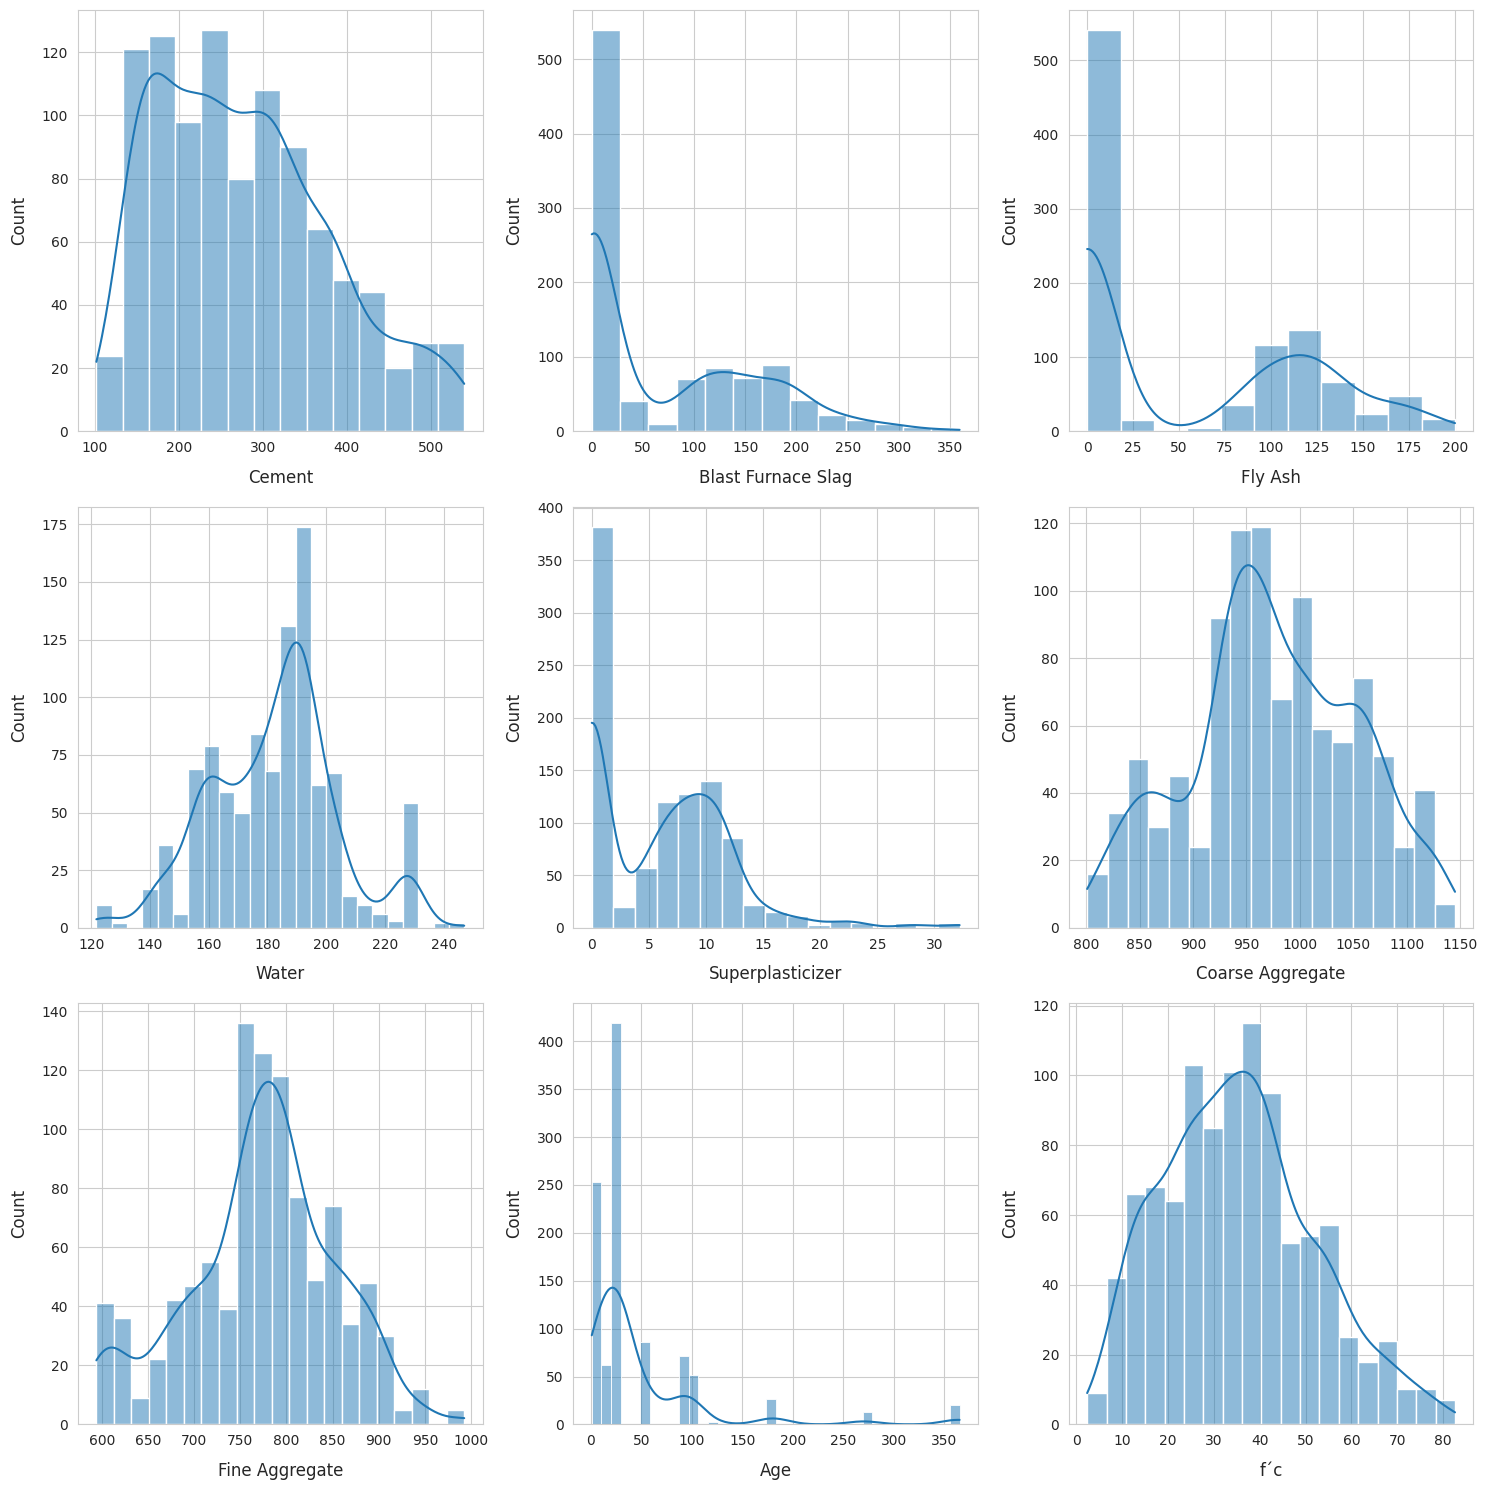

In [22]:
data.columns = data.columns.str.strip()


f, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=False)


sns.histplot(data['Cement'], ax=axes[0, 0], kde=True)
sns.histplot(data['Blast Furnace Slag'], ax=axes[0, 1], kde=True)
sns.histplot(data['Fly Ash'], ax=axes[0, 2], kde=True)
sns.histplot(data['Water'], ax=axes[1, 0], kde=True)
sns.histplot(data['Superplasticizer'], ax=axes[1, 1], kde=True)
sns.histplot(data['Coarse Aggregate'], ax=axes[1, 2], kde=True)
sns.histplot(data['Fine Aggregate'], ax=axes[2, 0], kde=True)
sns.histplot(data['Age'], ax=axes[2, 1], kde=True)
sns.histplot(data["f´c"], ax=axes[2, 2], kde=True)

plt.tight_layout()
plt.show()


Obviamente, de estos gráficos podemos sacar conclusiones muy interesantes, pero como el objetivo es crear una red neuronal para la predicción de f'c, no entraré en mucho detalle y me centraré en lo más relevante.

📌 1. Cemento
La mayoría de las mezclas en la base de datos están dentro de un rango típico de dosificación, lo cual podría generar sesgos al "entrar el modelo" por falta de datos. La distribución del cemento es aproximadamente normal, con un ligero sesgo hacia la derecha, centrada en torno a los 300 kg/m³.

📌 2. Escoria de alto horno (Blast Furnace Slag) y cenizas volantes (Fly Ash)
Ambos presentan distribuciones altamente sesgadas a la derecha, con un gran número de muestras que tienen contenido nulo o muy bajo, lo cual puede sesgar el aprendizaje. Es importante normalizar la muestra antes de ingresarla a la red neuronal. Esto indica que muchos concretos no contienen estos materiales cementantes suplementarios (SCM). Sin embargo, su inclusión (en niveles moderados) ha demostrado mejorar la resistencia a edades posteriores debido a reacciones puzolánicas y latentes (Thomas, 2007).

📌 3. Agua
La distribución es más simétrica, centrada alrededor de 180 kg/m³. El contenido de agua afecta directamente la relación agua/cemento (w/c), que es uno de los factores más influyentes en la resistencia del concreto (Neville, 2011). A mayor contenido de agua para un mismo contenido de cemento, la resistencia disminuye.

📌 4. Superplastificante
Presenta un sesgo marcado a la derecha, lo que indica que en muchas mezclas no se utiliza aditivo o se usa en bajas cantidades. Sin embargo, su uso permite reducir el contenido de agua sin afectar la trabajabilidad, lo que conduce a mezclas con menor relación agua/cemento y, por lo tanto, mayor resistencia (Domone, 2008).

📌 5. Agregado Grueso y Fino
Ambos muestran distribuciones normales, lo cual es esperable, ya que la mayoría de las mezclas de concreto se diseñan para tener proporciones equilibradas. El contenido de agregados afecta la trabajabilidad, la relación pasta/aglomerante y la zona de transición interfacial (ITZ), siendo esta última un punto crítico en la resistencia (Mindess et al., 2003).

📌 6. Edad del concreto
El histograma muestra una gran concentración de datos en los primeros 28 días, lo cual es esperable, dado que esta edad es el estándar para medir f'c. Sin embargo, también se observan valores hasta 365 días. Esto es relevante porque la resistencia del concreto no se desarrolla de forma lineal con el tiempo: el crecimiento es rápido en los primeros días y luego desacelera (Taylor, 1997).

📌 7. Resistencia a compresión (f'c)
La variable objetivo tiene una distribución bastante simétrica, centrada alrededor de 35 MPa, con un rango entre 5 y 80 MPa. Esta amplia dispersión refuerza la necesidad de considerar múltiples variables en conjunto, ya que la resistencia no depende de un solo insumo, sino de interacciones complejas entre varios factores.

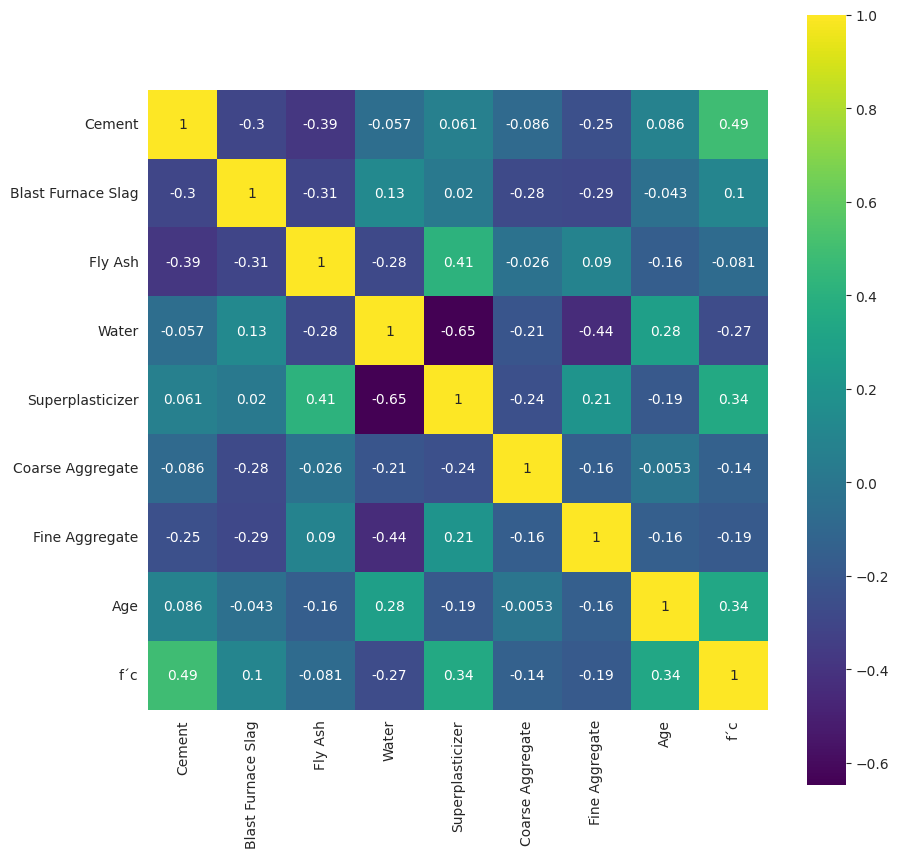

In [23]:
plt.figure(figsize=(10,10)) #se ajustará el tamaño de la figura

ax=sns.heatmap(data.corr(), vmax=1, square=True, annot=True, cmap="viridis") #se creará un mapa de calor de la correlación de los datos

Hay algunas conclusiones importantes que vale la pena resaltar, y a continuación daré mi humilde punto de vista al respecto.

Los agregados tienen poca o nula correlación con f'c
Esto sugiere que su efecto en la resistencia no es ni lineal ni dominante, o está más relacionado con propiedades indirectas como la zona de transición interfacial (ITZ), textura, forma o tamaño.

Fly Ash y Blast Furnace Slag: correlaciones débiles con f'c
Esto puede deberse a que su efecto depende del tiempo: ganan fuerza a edades más tardías (más allá de 28 días), lo que atenúa la correlación en general.



**¿Cómo funciona el machine learning?**

A grandes rasgos —porque este es un campo fascinante y bastante profundo—, te voy a explicar cómo funciona el machine learning y cómo, con conceptos básicos, podemos construir una red neuronal.

Primero, es importante mencionar que una neurona artificial (como yo llamo a las neuronas utilizadas en redes de machine learning) funciona de manera similar a una neurona biológica.

Imagina que una persona tiene solo una neurona. Esto implicaría que esa persona no podría tomar decisiones complejas, sino únicamente decisiones binarias: por ejemplo, hace frío o hace calor, el carro es azul o rojo. Es evidente entonces que, para poder tomar decisiones más complejas, necesitamos una red neuronal, capaz de captar y expresar múltiples señales al mismo tiempo. Pero, ¿cómo funciona una neurona?

Todo empieza en las dendritas, que son las encargadas de recibir información y enviarla al núcleo mediante impulsos eléctricos (paquetes de energía). Imagina ahora un día nublado y frío. Tus sentidos se activan y, a través de una red de neuronas, tu cuerpo trata de decidir si realmente tienes frío. Por ejemplo:

Vista: observas que el cielo está nublado y está lloviendo.

Tacto: al tocar una superficie, la sientes helada.

Olfato: no percibe ningún cambio relevante.

Las dendritas recogen esta información y le asignan una importancia o peso. Por ejemplo, solo con el tacto no puedes estar seguro de que hace frío (porque tocar una nevera fría no significa que el ambiente esté frío), así que le das un peso de 3/5. La vista, al mostrarte lluvia y nubes, tiene un peso de 5/5. El olfato no aporta en esta decisión, así que recibe un peso de 0.

El núcleo procesa esa información ponderada. Imagina que suma los aportes:
(3/5 + 5/5 + 0/5) ÷ 2 = 4/5

Ese resultado (4/5) representa una alta probabilidad de que sí está haciendo frío. Esa "respuesta" viaja entonces por el axón y llega al cuerpo, que reacciona: por ejemplo, decides ponerte una chaqueta.

Aclaro alo muy importante, este ejemplo corresponde a la abstracción matemática de las neuronas artificiales, no a la fisiología neuronal auténtica, sin embargo, a grandes rasgos, así funciona el machine learning: queremos simular matemáticamente el comportamiento de una neurona para predecir un fenómeno —físico o no— a partir de datos conocidos.
Entonces… ¿cómo lo podemos hacer?



¿Cómo podemos hacer una neurona artificial?

Lo primero que necesitamos son datos. Este campo fascinante depende de la calidad de los datos que puedas tener. Cada dato tendrá un peso o una importancia asociada a la calidad de la variable para predecir el problema. Entonces, imagina que tengo una base de datos con
𝑥1, 𝑥2, 𝑥3, 𝑥4 ... 𝑥𝑛, donde 𝑛 es el número de variables o características (features).

Por lo tanto, cada una de estas variables debe tener un peso asociado, el cual se relaciona con la importancia de la misma,
𝑤1, 𝑤2, 𝑤3, 𝑤4
, …, 𝑤𝑛
Por ende, nuestra primer conclusión es que Los pesos de interconexión w se utilizan para cuantificar la fuerza de las interconexiones; antes de que podamos sacar provecho de nuestra red neuronal es importante que esta aprenda o ser entrenada a partir de los datos entrada-salida se modifican lo pesos, ¿ves la importancia de w?

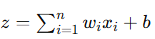

Observe, lector, que simplemente tendremos la sumatoria de cada una de las variables multiplicada por su peso más un término de sesgo 𝑏. Esto no debe traer mayor problema al lector, ya que es simplemente la ecuación de una recta con pendiente 𝑤, pero con una gran utilidad ya que nos da la salida de cada nodo el cual podemos propagar hacia adelante.

Con este valor
𝑧, el núcleo de la neurona ya puede tomar una decisión. Existen diversas funciones de activación, pero para este caso utilizaremos la función Swish, la cual funciona como una neurona sigmoide ponderada, lo que la vuelve muy efectiva a la hora de predecir. Pero, ¿qué es una función sigmoide? ¿Qué es una función Swish?

En términos sencillos, la función sigmoide —o logística— transforma cualquier número real en un valor entre 0 y 1, trazando una curva en forma de “S”. Su punto medio (cuando la entrada es 0) corta el eje Y en 0,5, lo que nos permite interpretar directamente su salida como una probabilidad. Así, si la sigmoide devuelve un valor menor que 0,5, podemos asociarlo a la decisión “no”; y si está por encima de 0,5, a la decisión “sí”. Esta propiedad de “mapeo probabilístico” facilita mucho las tareas de clasificación y toma de decisiones en modelos de aprendizaje automático.

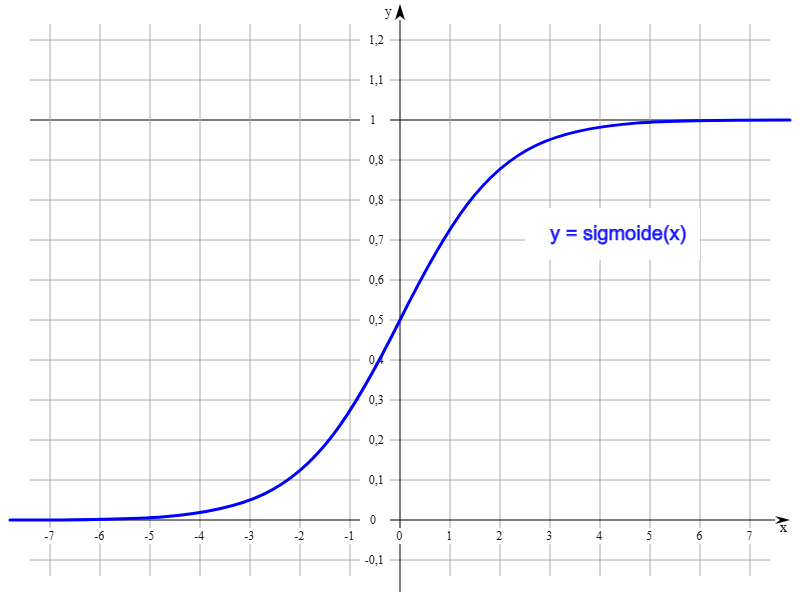




**¿Qué es la función swish (x) ?**

La función Swish es una activación suave y no monótona propuesta por investigadores de Google en 2017 que mejora el flujo de gradientes y el rendimiento de redes profundas frente a funciones tradicionales como ReLU o sigmoide. Matemáticamente se define como
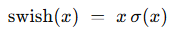
Donde σ(x) es la función sigmoide.

 Al combinar linealidad y saturación, Swish permite gradientes no nulos para valores negativos moderados y crece de forma más gradual que ReLU para valores grandes, favoreciendo la optimización y la expresividad del modelo.

Al saber mas a detalle como funciona una neurona artifical, podemos ingresar mas a fondo, pues, el objetivo es poder crear no una neurona, si no una red neuronal (Artificial Neural Network, ANN). Está compuesto por capas de unidades (neuronas artificiales) interconectadas por aristas ponderadas, que transforman señales de entrada en salidas mediante funciones de activación diferenciables. Durante el entrenamiento, un algoritmo de retropropagación ajusta estos pesos para minimizar un criterio de error sobre un conjunto de datos de entrenamiento, permitiendo a la red aproximar funciones complejas y realizar tareas como clasificación o regresión.

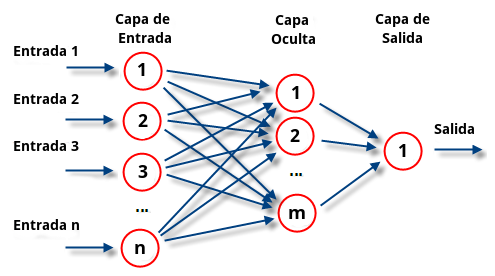



En una red neuronal artificial, tras la propagación hacia adelante, se obtiene un vector de predicciones 𝑦^ = 𝑓(𝑋;𝑊) a partir de los datos de entrada 𝑋
y los pesos actuales 𝑊 mediante operaciones lineales y funciones de activación en cada capa (swish)

Dado que en nuestro conjunto de entrenamiento disponemos de las etiquetas reales 𝑦, calculamos la función de pérdida 𝐿 (𝑦,𝑦^) (por ejemplo, entropía cruzada o error cuadrático medio) para cuantificar la discrepancia entre la salida de la red y el valor verdadero.

El objetivo del entrenamiento es minimizar el riesgo empírico sobre todos los ejemplos del conjunto de datos, definiendo así un problema de optimización supervisada.

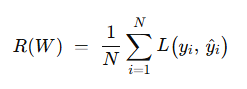

Para encontrar los pesos óptimos, se emplea el método de descenso de gradiente, el cual usamos las derivadas ( ∂J/∂w ) Para poder encontrar el camino de minima energia a la hora de modficar los pesos w.

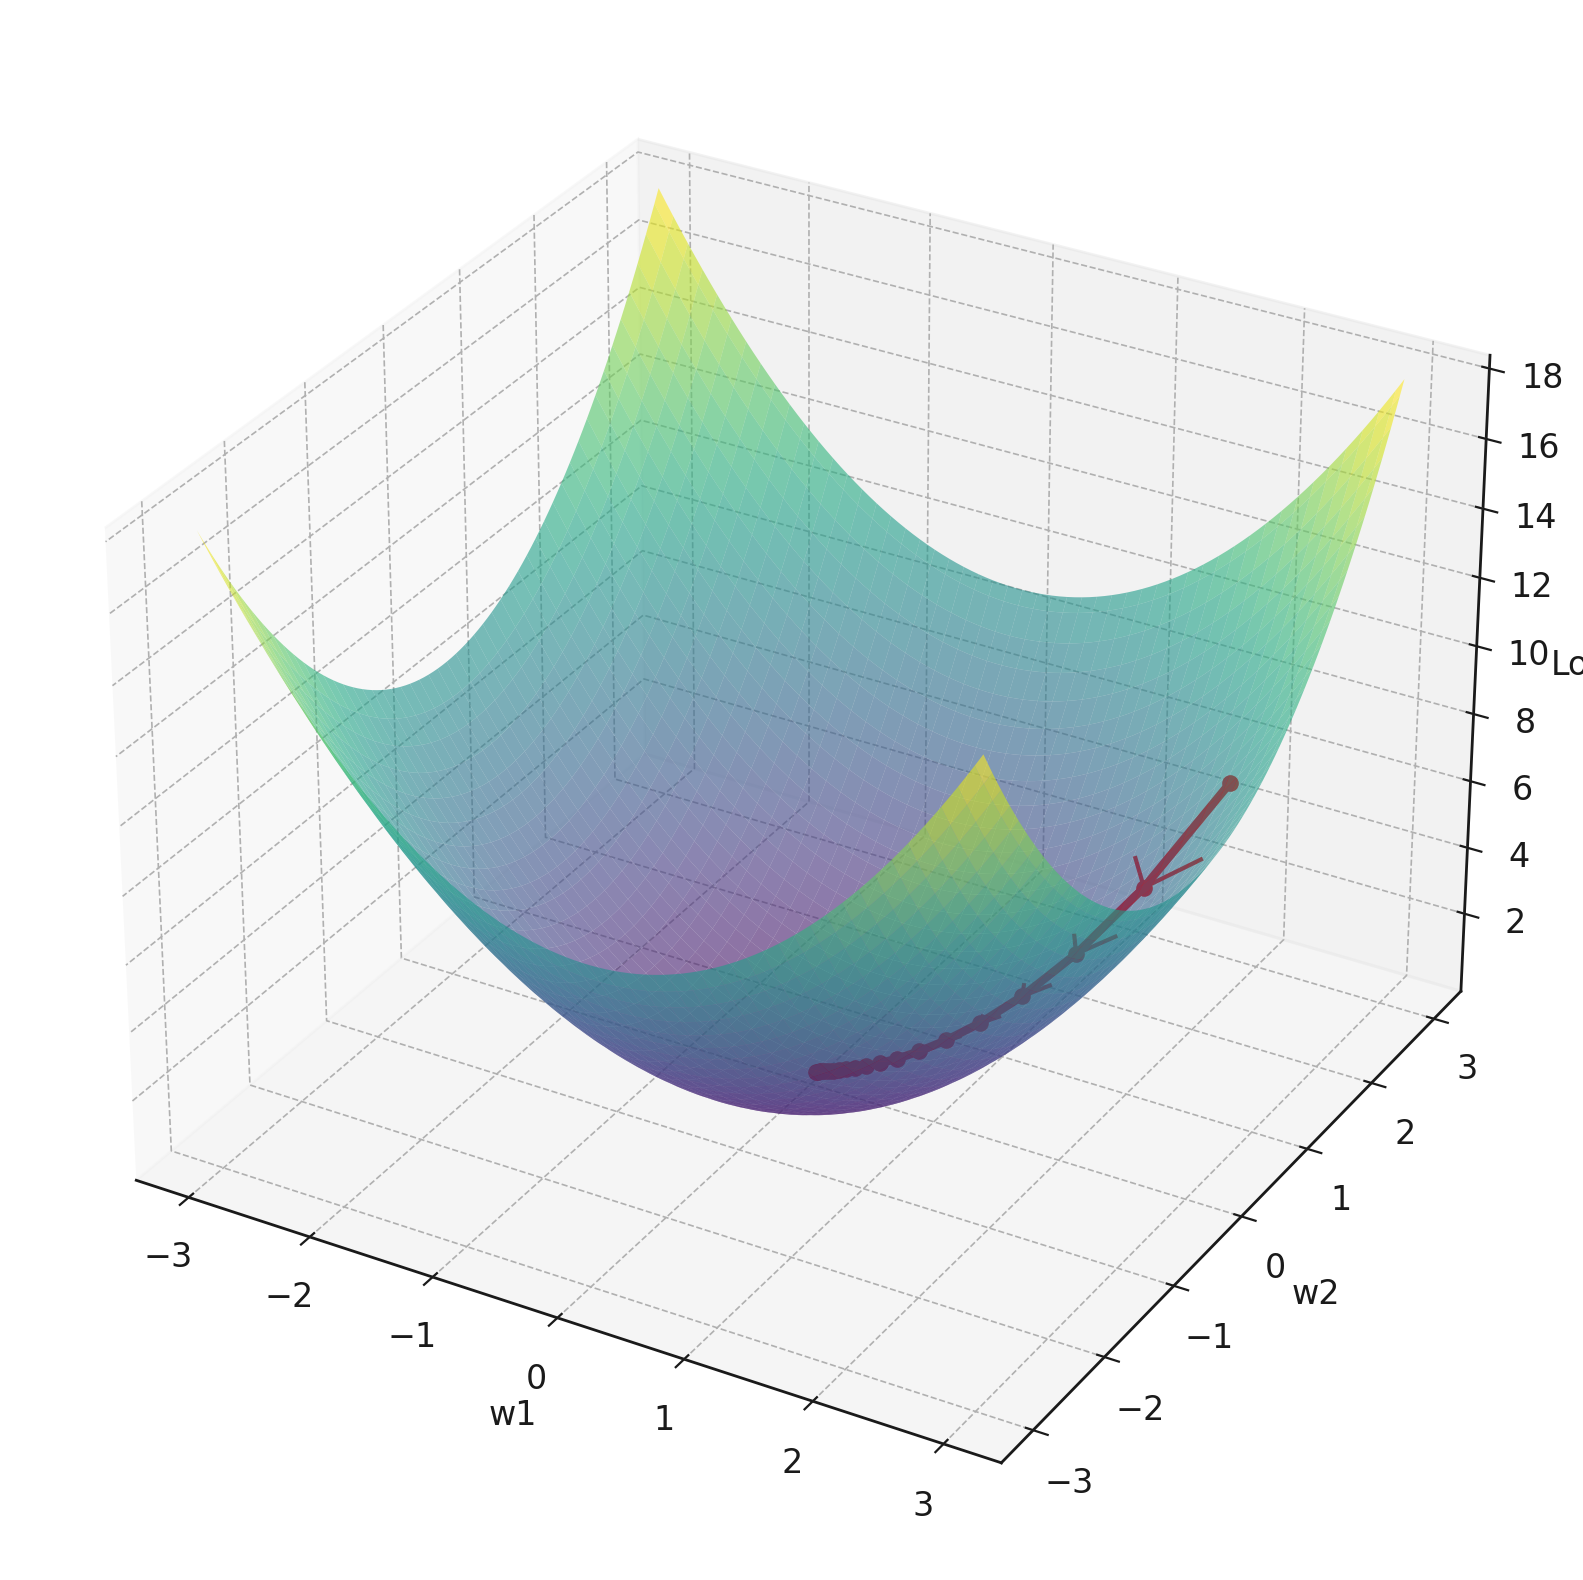

A continuación se muestra el script usado para estimar la resistencia del concreto. En él, implemento la función de activación Swish como parte del modelo de predicción.

Epoch 1/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 66.8702 - mae: 34.4335 - mse: 1443.0718 - val_loss: 71.3453 - val_mae: 36.6711 - val_mse: 1618.8983
Epoch 2/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 66.3439 - mae: 34.1704 - mse: 1437.4817 - val_loss: 70.9708 - val_mae: 36.4838 - val_mse: 1604.6654
Epoch 3/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 66.1292 - mae: 34.0630 - mse: 1401.7460 - val_loss: 70.5452 - val_mae: 36.2708 - val_mse: 1588.5776
Epoch 4/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 67.1959 - mae: 34.5963 - mse: 1462.2441 - val_loss: 70.0492 - val_mae: 36.0226 - val_mse: 1569.9810
Epoch 5/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 65.9277 - mae: 33.9622 - mse: 1410.6715 - val_loss: 69.4532 - val_mae: 35.7241 - val_mse: 1547.8323
Epoch 6/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 65.7823 - mae: 33.8895 - mse: 1405.7404 - val_loss: 68.7290 - val_mae: 35.3610 - val_mse: 1521.2235
Epoch 7/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms

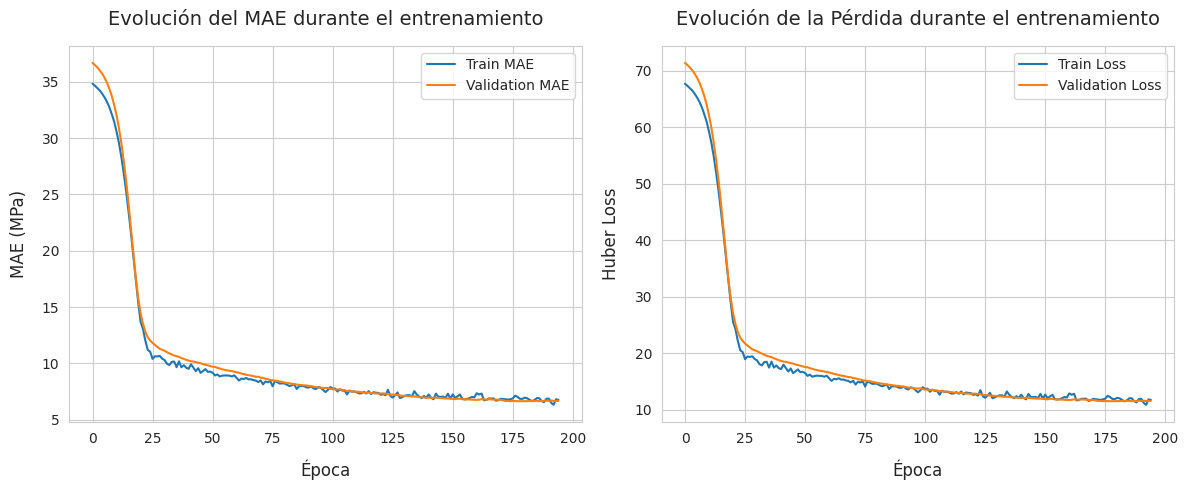

In [24]:
# Importar librerías
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Función de activación personalizada Swish
def swish(x):
    return x * tf.sigmoid(x)

# Función para construir el modelo de predicción de resistencia
def build_concrete_model(input_shape):
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),
        layers.BatchNormalization(),

        # Capa oculta 1
        layers.Dense(256, activation=swish,
                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                    bias_initializer='glorot_uniform'),
        layers.Dropout(0.4),

        # Capa oculta 2
        layers.Dense(128, activation=swish,
                    kernel_initializer='he_normal'),

        # Capa de salida (regresión)
        layers.Dense(1, activation='linear')
    ])

    optimizer = tf.keras.optimizers.Nadam(
        learning_rate=1e-4,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08
    )

    model.compile(
        loss=tf.keras.losses.Huber(delta=2.0),  # Delta ajustado para resistencia del concreto
        optimizer=optimizer,
        metrics=['mae', 'mse']
    )
    return model

# Configuración de early stopping
concrete_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=20,
    min_delta=0.01,
    mode='min',
    restore_best_weights=True
)


# Separar características y objetivo
X = data.drop('f´c', axis=1)
y = data['f´c']

# Normalización de características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División de datos (con shuffle para datos no temporales)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.15, shuffle=True, random_state=42
)

# Construir y entrenar el modelo
model = build_concrete_model((X_train.shape[1],))

history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[concrete_early_stopping],
    verbose=1
)

# Evaluación del modelo
def evaluate_concrete_model(model, X_test, y_test):
    results = model.evaluate(X_test, y_test)
    print("\nEvaluación final:")
    print(f"- MAE: {results[1]:.3f} MPa")
    print(f"- MSE: {results[2]:.3f} MPa²")
    print(f"- Pérdida Huber: {results[0]:.3f}")

    # Predicciones y análisis de error
    y_pred = model.predict(X_test)
    errors = np.abs(y_pred.flatten() - y_test)

    # Métricas adicionales
    print(f"\nError máximo: {np.max(errors):.2f} MPa")
    print(f"Error promedio: {np.mean(errors):.2f} MPa")
    print(f"Rango objetivo: {np.min(y):.1f}-{np.max(y):.1f} MPa")

    # Porcentaje dentro de tolerancias comunes
    within_5mpa = np.sum(errors <= 5.0) / len(y_test)
    within_10pct = np.sum(errors <= 0.1 * y_test) / len(y_test)

    print(f"\nDentro de ±5 MPa: {within_5mpa*100:.1f}%")
    print(f"Dentro de ±10% del valor real: {within_10pct*100:.1f}%")

# Visualización del entrenamiento
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Evolución del MAE durante el entrenamiento')
    plt.ylabel('MAE (MPa)')
    plt.xlabel('Época')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Evolución de la Pérdida durante el entrenamiento')
    plt.ylabel('Huber Loss')
    plt.xlabel('Época')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Ejecutar evaluación y visualización
evaluate_concrete_model(model, X_test, y_test)
plot_training_history(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


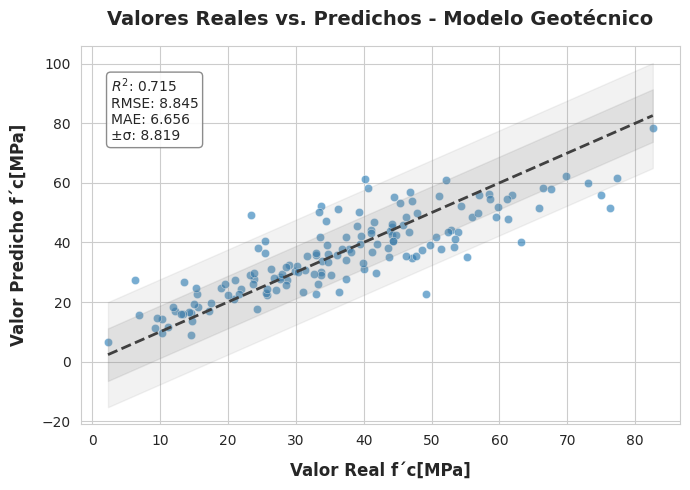

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predecir
y_pred = model.predict(X_test).flatten()

# Calcular métricas
residuals = y_test - y_pred
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
std_residual = np.std(residuals)

# Estilo
sns.set_style("whitegrid")
sns.set_palette("tab10")
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Gráfica
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x=y_test,
    y=y_pred,
    alpha=0.6,
    edgecolor='white',
    linewidth=0.5
)

# Línea identidad
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='#404040', lw=2)

# Bandas ±σ y ±2σ
for n_std in [1, 2]:
    plt.fill_between(
        [min_val, max_val],
        [min_val - n_std * std_residual, max_val - n_std * std_residual],
        [min_val + n_std * std_residual, max_val + n_std * std_residual],
        color='gray',
        alpha=0.2 - 0.05 * n_std,
    )

# Métricas en caja de texto
metric_text = (
    f'$R^2$: {r2:.3f}\n'
    f'RMSE: {rmse:.3f}\n'
    f'MAE: {mae:.3f}\n'
    f'±σ: {std_residual:.3f}'
)
plt.gca().text(
    0.05, 0.75, metric_text,
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', boxstyle='round')
)

# Etiquetas
plt.xlabel('Valor Real f´c[MPa]', fontweight='bold')
plt.ylabel('Valor Predicho f´c[MPa]', fontweight='bold')
plt.title('Valores Reales vs. Predichos - Modelo Geotécnico', pad=15, fontweight='bold')

# Layout
plt.tight_layout()
plt.show()

Es evidente que se puede hacer uso de redes neuronales para predecir el comportamiento del concreto o, en este caso, calcular su resistencia a la compresión (f´c). Es importante recordar que este valor no es lineal, y su no linealidad se incrementa con el aumento de la resistencia del concreto. Por lo tanto, encontrar una metodología que permita obtener resultados más precisos y facilite la predicción de la cantidad de materiales, o una mejor comprensión del funcionamiento del concreto, resulta esencial.

Sin embargo, ¿existe una forma más precisa de predecir este valor?



In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_excel("Concrete_Data.xls")
print(data.columns.tolist())

data.head()

['Cement ', 'Blast Furnace Slag ', 'Fly Ash ', 'Water  ', 'Superplasticizer ', 'Coarse Aggregate ', 'Fine Aggregate', 'Age ', 'f´c ']


,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,f´c
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


Cuando se trata de predecir propiedades mecánicas —por ejemplo, la resistencia a compresión del concreto— los datos suelen presentar no linealidades crecientes con valores altos del atributo de interés. Los métodos clásicos lineales quedan cortos; por ello, los algoritmos basados en ensamblados de árboles y máquinas de vectores de soporte adaptadas se han convertido en la elección preferida para tareas de regresión compleja. En este texto exploraremos cómo funciona cada técnica y en qué escenarios brilla cada una.

XGBoost: impulsando el gradiente extremo
XGBoost (eXtreme Gradient Boosting) es una evolución de la técnica de boosting, centrada en mejorar tanto la velocidad como la precisión de los modelos basados en árboles de decisión. Su fuerza reside en:

Boosting secuencial
Cada nuevo árbol se ajusta a los residuos del conjunto de árboles anteriores, de manera que el ensamblado corrige progresivamente los errores del modelo global.

Aproximación de segundo orden
A diferencia de las implementaciones básicas de boosting, XGBoost utiliza tanto la primera como la segunda derivada de la función de pérdida, lo que acelera la convergencia y ofrece estimaciones más estables de la mejora en cada división.

Regularización integrada
Incluye penalizaciones en la complejidad de los árboles (por ejemplo, a través de la profundidad o el peso de las hojas), reduciendo el riesgo de sobreajuste y mejorando la capacidad de generalización.

Optimización y paralelismo
Está diseñado para aprovechar múltiples núcleos de CPU e incluso GPU, así como entornos distribuidos, lo que permite entrenar conjuntos de datos muy grandes en tiempo razonable.

Gracias a estas características, XGBoost es especialmente útil cuando se cuenta con volúmenes de datos significativos y se busca exprimir cada fracción de precisión adicional.

Random Forest: robustez mediante bagging
Random Forest aborda la predicción desde la perspectiva del “bagging” (bootstrap aggregating). Su filosofía es sencilla pero poderosa:

Muestreo con reemplazo
Cada árbol del bosque se entrena sobre un subconjunto aleatorio de las observaciones originales, lo que introduce variabilidad y disminuye la correlación entre árboles.

Selección aleatoria de variables
En cada nodo de división, solo un subconjunto aleatorio de las características está disponible para elegir, lo que diversifica aún más las particiones y evita que características dominantes acaparen todas las divisiones.

Agregación de salidas
Para regresión, las predicciones de todos los árboles se promedian; para clasificación, se toma la mayoría de votos. Este proceso de votación o promedio reduce la varianza total del modelo sin sacrificar el sesgo de forma significativa.

Estimación integrada del error
Las muestras no seleccionadas en el muestreo de un árbol (out‑of‑bag) sirven para evaluar de forma interna la calidad de la predicción, eliminando la necesidad de un conjunto de validación adicional.

Random Forest suele requerir poca parametrización y es muy resistente a ruidos y valores atípicos, lo que lo hace ideal para aplicaciones en las que se busca rapidez de implementación y solidez.

LS‑SVR: regresión por mínimos cuadrados en espacio de alta dimensión
Least Squares Support Vector Regression adapta el poderoso marco de las máquinas de vectores de soporte al entorno de regresión mediante una formulación de mínimos cuadrados:

Pérdida de cuadrados mínimos
Sustituye la clásica “ε‑insensible” por una penalización cuadrática de los errores, lo que convierte el entrenamiento en la resolución de un único sistema lineal.

Kernel trick
Permite trabajar en espacios de características de alta o incluso infinita dimensión (polinómico, RBF, sigmoidal, etc.) sin calcular explícitamente las transformaciones, capturando así relaciones muy complejas entre variables.

Solución directa
La reformulación en un sistema de ecuaciones lineales acelera el proceso de ajuste en comparación con las optimizaciones cuadráticas iterativas de SVR estándar, aunque puede aumentar la sensibilidad al ruido de los datos.

Control de regularización
Un parámetro λ (o γ) ajusta el equilibrio entre el tamaño del error y la complejidad del modelo, permitiendo encontrar un punto óptimo entre ajuste ajustado y generalización.

LS‑SVR resulta especialmente útil cuando se dispone de conjuntos de datos de tamaño moderado y se desea explotar kernels complejos sin incurrir en los costos computacionales de un entrenamiento iterativo intenso.

<ipython-input-27-a06295cb0a1e>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-27-a06295cb0a1e>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-27-a06295cb0a1e>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


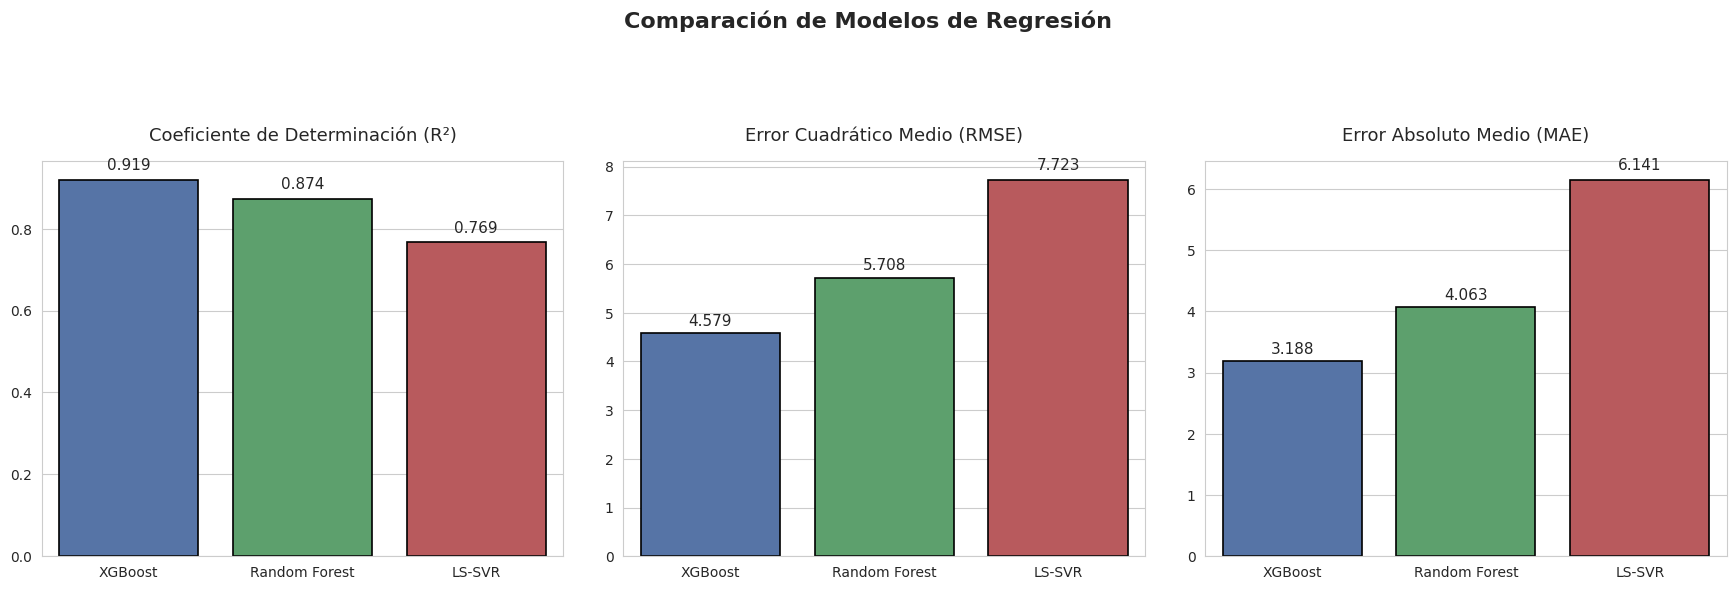


Resumen de Métricas de Rendimiento:


,R2,RMSE,MAE
Modelo,,,
XGBoost,0.919,4.579,3.188
Random Forest,0.874,5.708,4.063
LS-SVR,0.769,7.723,6.141


In [27]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_palette("colorblind")
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.titlepad': 15,
    'axes.labelpad': 10
})

# Cargar datos y preparación
X = data.drop('f´c ', axis=1)
y = data['f´c ']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Configuración de modelos
models = {
    "XGBoost": XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.9,
        random_state=42
    ),
    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        bootstrap=True,
        random_state=42
    ),
    "LS-SVR": SVR(
        kernel='rbf',
        C=7.842342,
        gamma=0.027305,
        epsilon=0.000563
    )


}

# Evaluación de modelos
results = {}
for name, model in models.items():
    if name == "LS-SVR":
        X_tr = X_train_scaled
        X_te = X_test_scaled
    else:
        X_tr = X_train
        X_te = X_test

    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)

    results[name] = {
        'R2': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    }

# graficos
metrics_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Modelo'})
melt_df = metrics_df.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')


fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
plt.suptitle('Comparación de Modelos de Regresión', y=1.02, fontsize=16, fontweight='semibold')
palette = {"XGBoost": "#4C72B0", "Random Forest": "#55A868", "LS-SVR": "#C44E52"}


for i, metric in enumerate(['R2', 'RMSE', 'MAE']):
    subset = metrics_df[['Modelo', metric]]

    # Gráfico de barras
    sns.barplot(
        x='Modelo',
        y=metric,
        data=subset,
        ax=ax[i],
        palette=palette,
        edgecolor='black',
        linewidth=1.2,
        saturation=0.8
    )

    # Personalización del subgráfico
    ax[i].set_title({
        'R2': 'Coeficiente de Determinación (R²)',
        'RMSE': 'Error Cuadrático Medio (RMSE)',
        'MAE': 'Error Absoluto Medio (MAE)'
    }[metric], fontsize=13)

    ax[i].set_xlabel('')
    ax[i].set_ylabel('')


    for p in ax[i].patches:
        height = p.get_height()
        ax[i].text(p.get_x() + p.get_width()/2., height * 1.02,
                 f'{height:.3f}',
                 ha='center', va='bottom', fontsize=11)



plt.tight_layout(pad=3.0)
plt.show()


print("\nResumen de Métricas de Rendimiento:")
display(metrics_df.set_index('Modelo').style
       .format({'R2': '{:.3f}', 'RMSE': '{:.3f}', 'MAE': '{:.3f}'})
       .background_gradient(cmap='Blues', axis=0)
       .set_caption("Resultados de Evaluación en Conjunto de Prueba"))


<ipython-input-28-5961f27da825>:79: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', frameon=True, framealpha=0.9)


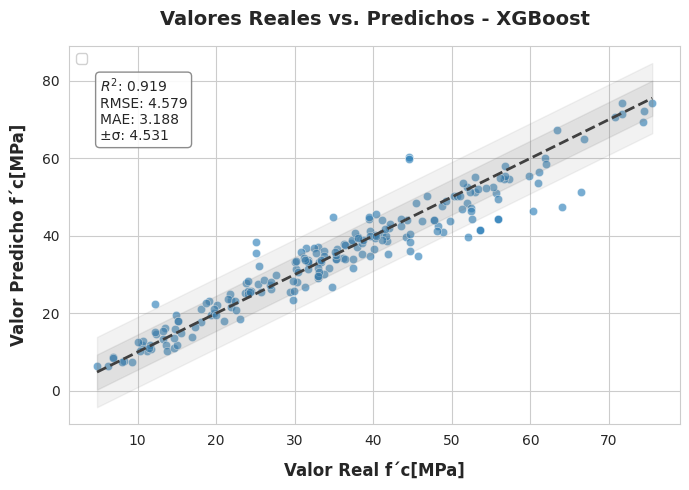

In [28]:
sns.set_style("whitegrid")
sns.set_palette("tab10")
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})


model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


# CÁLCULO DE MÉTRICAS
residuals = y_test - y_pred
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
std_residual = np.std(residuals)



# GRÁFICA: VALORES REALES vs. PREDICCIONES

plt.figure(figsize=(7, 5))
sns.scatterplot(
    x=y_test,
    y=y_pred,
    alpha=0.6,
    edgecolor='white',
    linewidth=0.5
)

max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='#404040', lw=2,)

# Bandas de ±1σ y ±2σ alrededor de la línea de identidad
for n_std in [1, 2]:
    plt.fill_between(
        [min_val, max_val],
        [min_val - n_std * std_residual, max_val - n_std * std_residual],
        [min_val + n_std * std_residual, max_val + n_std * std_residual],
        color='gray',
        alpha=0.2 - 0.05 * n_std,

    )


metric_text = (
    f'$R^2$: {r2:.3f}\n'
    f'RMSE: {rmse:.3f}\n'
    f'MAE: {mae:.3f}\n'
    f'±σ: {std_residual:.3f}'
)

plt.gca().text(
    0.05, 0.75, metric_text,
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', boxstyle='round')
)

# Etiquetas y título
plt.xlabel('Valor Real f´c[MPa]', fontweight='bold')
plt.ylabel('Valor Predicho f´c[MPa]', fontweight='bold')
plt.title('Valores Reales vs. Predichos - XGBoost', pad=15, fontweight='bold')

# Leyenda y layout
plt.legend(loc='upper left', frameon=True, framealpha=0.9)
plt.tight_layout()
plt.show()
